In [ ]:
!pip install -q condacolab

import condacolab
condacolab.install()

# install ngspice packages, including executables & master package
!conda install -c conda-forge ngspice-exe  
!conda install -c conda-forge ngspice      
!conda install -c conda-forge ngspice-lib

!pip install PySpice

!pyspice-post-installation --check-install


In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()

from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *

In [ ]:
#################
# 1. Физические константы:
#################

#*Заряд электрона [Кл]
qe = 1.6e-19
#Масса электрона [кг]
me = 9.11e-31
#Масса иона Ar [кг]
Mi = 1.67e-27
#Постоянная Больцмана [Дж/К]
k_B = 1.38e-23
#Электрическая постоянная [Ф/м]
eps_0 = 8.85e-12

#################
# 2. Варьируемые параметры разряда:
#################

#Амплитуда возбуждающего поля [V]
Vm = 100
#Частота возбуждающего поля [Гц]
f0 = 13.56e+6
#Период возбуждающего поля [с]
Tf = 1/f0
#Давление газа [Па]
p0 = 0.66
#Температура буферного газа [К]
T0 = 300
#Концентрация нейтральных атомов [м^-3]
ng = p0/(k_B*T0)
#Электронная плотность [м^-3]
ne = 1.25e+15
#Электронная температура [эВ]
Te = 4.73
#Толщина bulk плазмы [м]
l_B = 5.7e-2
#Коэффициент электронно-нейтральных столкновений [м^3*с^-1]
Km = 1e-13
#Частота электронно-нейтральных столкновений [c^-1]
nu_el_netr = Km*ng

#################
# 3. Скорости электронов и ионов [м/с]:
#################

#Бомовская скорость ионов
v_Bomh = math.sqrt(qe*Te/Mi)
#Средняя тепловая скорость электронов
v_midd_e = math.sqrt(8*qe*Te/(3.14*me))
#Площадь управляющего электрода [м^2]
Ae = 0.01
#Площадь заземленного электрода [м^2]
Ag = 3*Ae
#Эффективная частота электронно-нейтральных столкновений [c^-1]
nu_eff = nu_el_netr+(v_midd_e/l_B)

#################
# 4. Вычисляемые величины
#################

#Амплитуда электронного тока у управляющего электрода [А]
Ie01 = qe*ne*v_midd_e*Ae
#Амплитуда электронного тока у заземленного электрода [А]
Ie02 = qe*ne*v_midd_e*Ag
#Коэффициент показателя экспоненты электронного тока
alpha = -1/Te
#Полный ионный ток на управляющий электрод [А]
Iion1 = qe*ne*v_Bomh*Ae
#Полный ионный ток на заземленный электрод [А]
Iion2 = qe*ne*v_Bomh*Ag
#Коэффициент при емкости слоя управляющего электрода
CCs1 = (qe*ne*eps_0*Ae**2)/2
#Коэффициент при емкости слоя заземленного электрода
CCs2 = (qe*ne*eps_0*Ag**2)/2
#Индуктивность bulk плазмы [Гн]
Lp = l_B*me/(qe**2*ne*Ae)
#Сопротивление bulk плазмы [Ом]
Rp = nu_eff*Lp

#################
# 5. Настройки анализа Ngspice
#################
Tf=1/f0

#Количество периодов ВЧ поля, которое надо просчитать
num_periods_sim=500

tmax_sim = Tf*num_periods_sim
tmin_sim = Tf*(num_periods_sim-5)
timestep_output = Tf/100

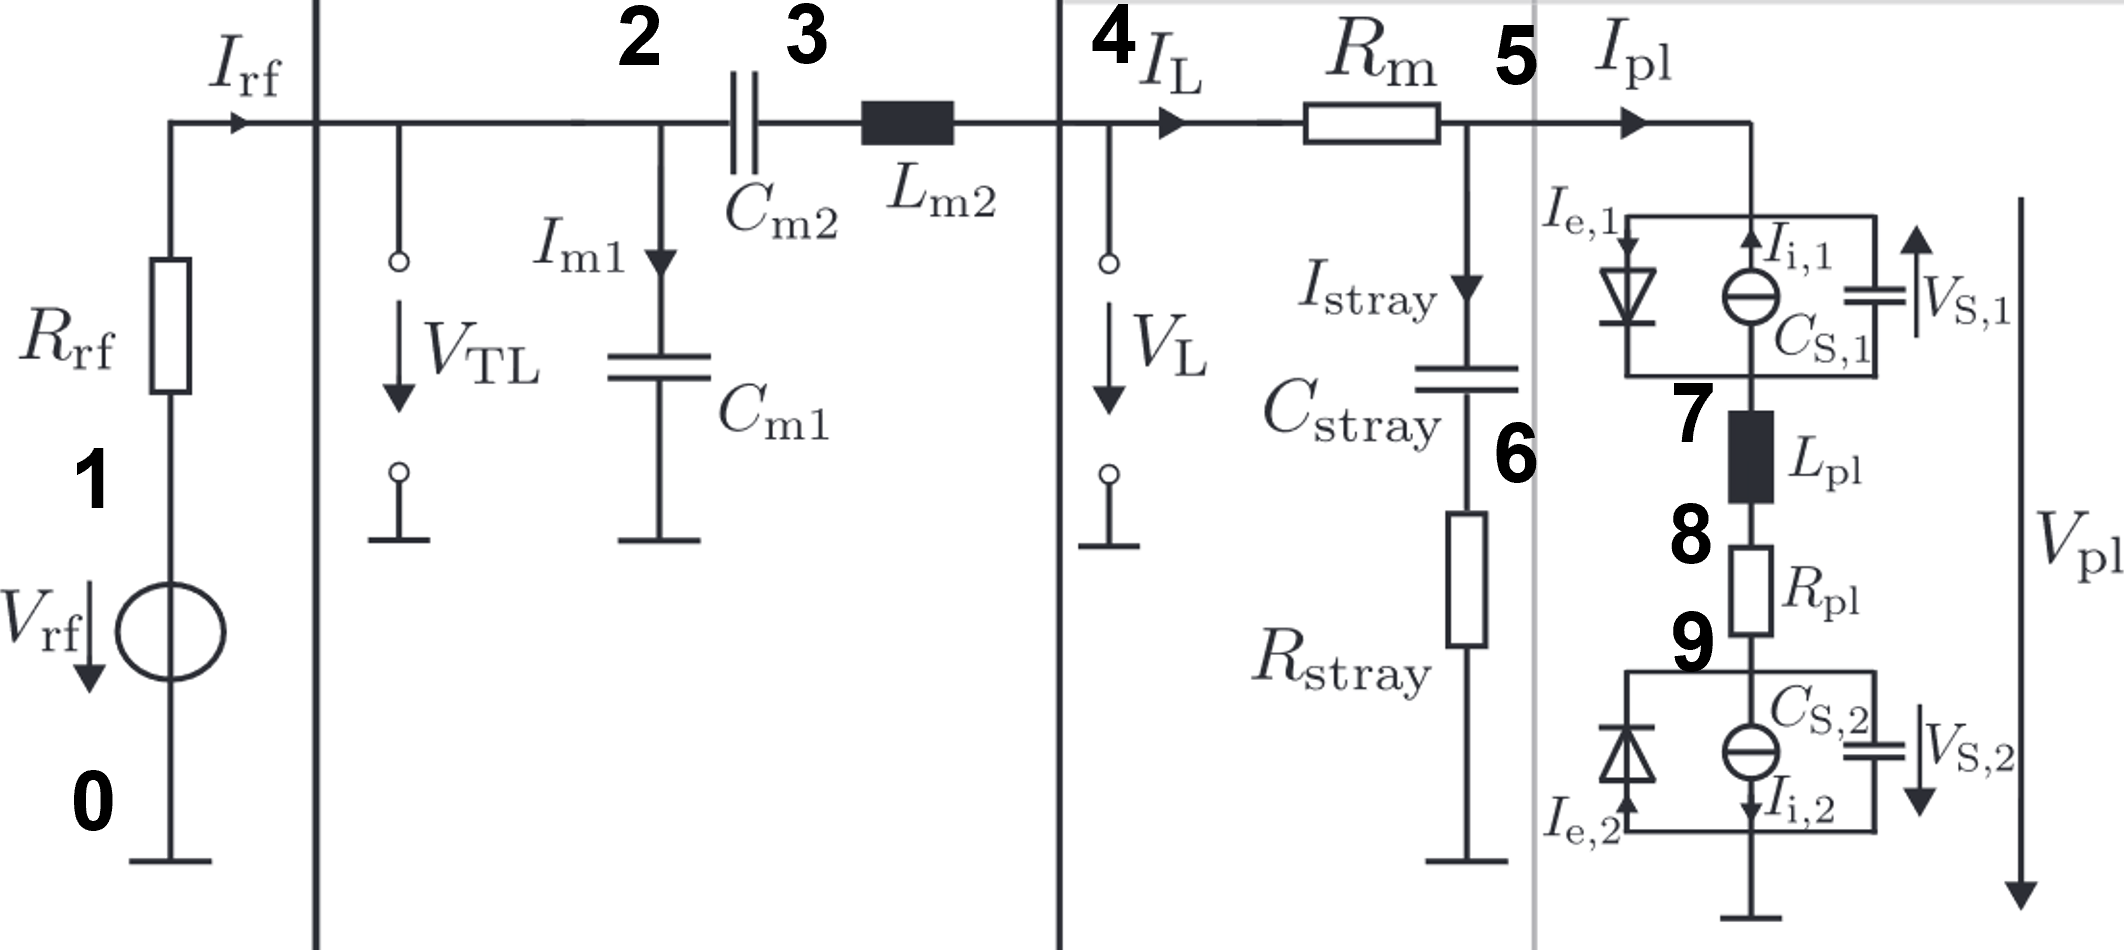

In [ ]:
circuit = Circuit('RF discharge impedance')

val_R_rf = 50
val_C_m1 = 1550e-12
val_C_m2 = 175e-12
val_L_m2 = 1500e-9
val_R_m = 0.5
val_C_stray = 200e-12
val_R_stray = 0.5

circuit.SinusoidalVoltageSource('V0', 1, 0, amplitude = Vm, frequency = f0)
circuit.R('Rrf', 1, 2, val_R_rf)
circuit.C('Cm1', 2, 0, val_C_m1)
circuit.C('Cm2', 2, 3, val_C_m2)
circuit.L('Lm2', 3, 4, val_L_m2)
circuit.R('Rm', 4, 5, val_R_m)
circuit.C('Cstray', 5, 6, val_C_stray)
circuit.R('Rstray', 6, 0, val_R_stray)
circuit.BehavioralSource('Be_e', 5, 7, current_expression=f'v(7,5) > 0 ? {Ie01}*exp({alpha}*v(7,5)) : 1e-12')
circuit.CurrentSource('Bi_e', 7, 5, Iion1)
circuit.BehavioralCapacitor('Cs1', 7, 5, capacitance_expression=f'C=\'sqrt({CCs1}/abs(v(7,5)))\'')
circuit.L('L_p', 7, 8, Lp)
circuit.R('R_p', 8, 9, Rp)
circuit.BehavioralSource('Be_g', 10, 9, current_expression=f'v(9,10) > 0 ? {Ie02}*exp({alpha}*v(9,10)) : 1e-12')
circuit.CurrentSource('Bi_g', 9, 10, Iion2)
circuit.BehavioralCapacitor('Cs2', 9, 10, capacitance_expression=f'C=\'sqrt({CCs2}/abs(v(9,10)))\'')
circuit.VoltageSource('Viz', 10, 0, 0)

#print(circuit) # Можно напечатать получившийся netlist для проверки


VoltageSource VViz

In [ ]:
simulator = circuit.simulator()
simulator._initial_condition={'v(5)':1e-10, 'v(9)':1e-10}
#simulator.initial_condition['v(5)']=1e-10

#print(simulator) # Можно напечатать .IC для проверки
analysis = simulator.transient(step_time=Tf/100, end_time=tmax_sim)

.title RF discharge impedance
VV0 1 0 DC 0V AC 1V SIN(0V 100V 13560000.0Hz 0s 0Hz)
RRrf 1 2 50
CCm1 2 0 1.55e-09
CCm2 2 3 1.75e-10
LLm2 3 4 1.5e-06
RRm 4 5 0.5
CCstray 5 6 2e-10
RRstray 6 0 0.5
BBe_e 5 7 i=v(7,5) > 0 ? 2.9096552741612896*exp(-0.2114164904862579*v(7,5)) : 1e-12
IBi_e 7 5 0.042575751441148314
CCs1 7 5 C='sqrt(8.85e-20/abs(v(7,5)))'
LL_p 7 8 1.6227187500000004e-07
RR_p 8 9 6.728655364096571
BBe_g 10 9 i=v(9,10) > 0 ? 8.728965822483868*exp(-0.2114164904862579*v(9,10)) : 1e-12
IBi_g 9 10 0.12772725432344492
CCs2 9 10 C='sqrt(7.965e-19/abs(v(9,10)))'
VViz 10 0 0
.options TEMP = 27C
.options TNOM = 27C
.ic v(5)=1e-10 v(9)=1e-10
.end



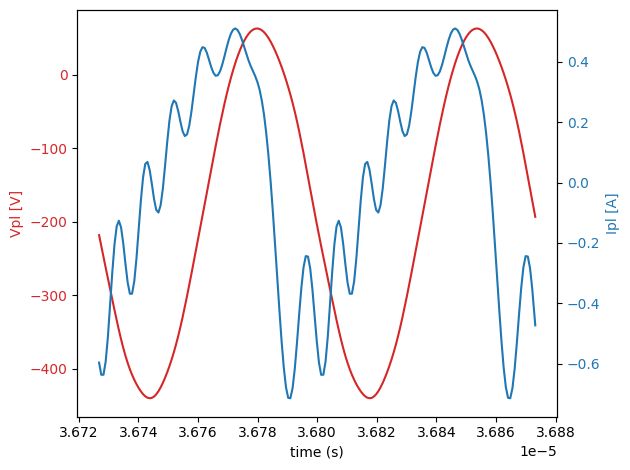

In [ ]:
time_data = np.array(analysis.time)

v5_data = np.array(analysis['5'])
v9_data = (np.array(analysis['8'])-np.array(analysis['9']))/Rp


fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Vpl [V]', color=color)
ax1.plot(time_data[-200:], v5_data[-200:], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Ipl [A]', color=color)  # we already handled the x-label with ax1
ax2.plot(time_data[-200:], v9_data[-200:], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
*Plasma Current Model
*1. Константы:
*Заряд электрона [Кл]
.param qe = 1.6e-19
*Масса электрона [кг]
.param me = 9.11e-31
*Масса иона аргона [кг]
.param Mi = 1.67e-27
*Постоянная Больцмана [Дж/К]
.param k_B = 1.38e-23
*Электрическая постоянная [м^-3*кг^-1*с^4*А^2]
.param eps_0 = 8.85e-12

*2. Варьируемые параметры разряда:
*Амплитуда возбуждающего поля [V]
.param Vm = 100
*Частота возбуждающего поля [с^-1]
.param f0 = 13.56e+6
*Период возбуждающего поля [с]
.param Tf = 1/f0
*Начальное давление газа [Па]
.param p0 = 0.66
*Начальная температура газа [К]
.param T0 = 300
*Концентрация нейтральных атомов [м^-3]
.param ng = p0/(k_B*T0)
*Электронная плотность [м^-3]
.param ne = 1.25e+15
*Электронная температура [эВ]
.param Te = 4.73
*Толщины плазмы [м]
.param l_B = 5.7e-2
*Коэффициент электронно-нейтральных столкновений [м^3*с^-1]
.param Km = 1e-13
*Частота электронно-нейтральных столкновений [c^-1]
.param nu_el_netr = Km*ng

*3. Скорости электронов и ионов [м/с]:
*Бомовская скорость ионов
.param v_Bomh = sqrt(qe*Te/Mi)
*Средняя тепловая скорость электронов
.param v_midd_e = sqrt(8*qe*Te/(3.14*me))
*Площадь управляющего электрода [м^2]
.param Ae = 0.01
*Площадь заземленного электрода [м^2]
.param Ag = 3*Ae
*Эффективная частота электронно-нейтральных столкновений [c^-1]
.param nu_eff = nu_el_netr+(v_midd_e/l_B)

*4. Величины электронного и ионного токов [А]:
*Амплитуда электронного тока у управляющего электрода
.param Ie01 = qe*ne*v_midd_e*Ae
*Амплитуда электронного тока у заземленного электрода
.param Ie02 = qe*ne*v_midd_e*Ag
*Коэффициент показателя экспоненты электронного тока
.param alpha = -1/Te
*Величина ионного тока на управляющий электрод
.param Iion1 = qe*ne*v_Bomh*Ae
*Величина ионного тока на заземленный электрод
.param Iion2 = qe*ne*v_Bomh*Ag

*5. Номиналы эквивалетных элементов цепи:
*Коэффициент при переменной емкости оболочки у правляющего электрода
.param CCs1 = (qe*ne*eps_0*Ae^2)/2
*Коэффициент при переменной емкости оболочки у правляющего электрода
.param CCs2 = (qe*ne*eps_0*Ag^2)/2
*Индуктивность плазмы [Гн]
.param Lp = l_B*me/(qe^2*ne*Ae)
*Сопротивление плазмы [Ом]
.param Rp = nu_eff*Lp

*6. Параметры для вывода на экран
.csparam ng_cs = ng
.csparam nu_el_netr_cs = nu_el_netr
.csparam v_Bomh_cs = v_Bomh
.csparam v_midd_e_cs = v_midd_e
.csparam nueff_cs = nu_eff
.csparam Ie01_cs = Ie01
.csparam Ie02_cs = Ie02
.csparam Iion1_cs = Iion1
.csparam Iion2_cs = Iion2
.csparam CCs1_cs = CCs1
.csparam CCs2_cs = CCs2
.csparam Lp_cs = Lp
.csparam Rp_cs = Rp

*7. Нетлист:
*7.1 Источник и его внутреннее сопротивление
Vrf 1 0 sin(0, Vm, f0)
Rrf 1 2 50
*7.2 Паразитные элементы внешней цепи
Cm1 2 0 1550p
Cm2 2 3 175p
Lm2 3 4 1500n
Rm 4 5 0.5
Cstray 5 6 200p
Rstray 6 0 0.5
*7.3 Слой у нагруженного электрода
Be_e 5 7 I = v(7,5) > 0 ? Ie01*exp(alpha*v(7,5)) : 1e-12
Bi_e 7 5 I = Iion1
Cs1 7 5 C = 'sqrt(CCs1/abs(v(7,5)))'
*7.4 Тело плазмы
L_p 7 8 L = 'Lp'
R_p 8 9 r = 'Rp'
*7.5 Слой у заземленного электрода
Be_g 10 9 I = v(9,10) > 0 ? Ie02*exp(alpha*v(9,10)) : 1e-12
Bi_g 9 10 I = Iion2
Cs2 9 10 C = 'sqrt(CCs2/abs(v(9,10)))'
*7.6 Измеритель тока 
Viz 10 0 0
.control
tran 0.001u 80u
plot xlimit 70u 70.3u v(5)
plot xlimit 70u 70.3u i(Viz)
fft i(Viz) v(5)
linarize
plot xlimit 0 80Meg ylog mag(i(Viz))
plot xlimit 0 80Meg ylog mag(v(5))
plot xlimit 0 80Meg ylog mag(v(5))/mag(i(Viz))

echo n_g = $&ng_cs
echo nu_elnetr = $&nu_el_netr_cs
echo vBomh =  $&v_Bomh_cs
echo vmidd_e = $&v_midd_e_cs
echo I_e1 = $&Ie01_cs
echo I_e2 = $&Ie02_cs
echo Iion_1 = $&Iion1_cs
echo Iion_2 = $&Iion2_cs
echo CCs_1 = $&CCs1_cs
echo CCs_2 = $&CCs2_cs
echo nueff = $&nueff_cs
echo Rplas = $&Rp_cs
echo Lplas = $&Lp_cs

*wrdata I_plas.txt i(Viz)
*wrdata V_plas.txt v(5)
*wrdata magI_plas.txt mag(i(Viz))
*wrdata magV_plas.txt mag(v(5))
*wrdata Z_plas.txt mag(v(5))/mag(i(Viz))

.endc
.end